<a href="https://colab.research.google.com/github/Marangrang/Detecting-Fraudulent-Credit-Card-Transactions/blob/master/Marangrang__Xente_Fraud_Detection_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Honour Code¶
I Marangrang, Tsepetsi, confirm - by submitting my - that the solutions in this notebook are a result of my own work and that I abide by the EDSA honour code (https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

In [0]:
# Import all the libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from imblearn.combine import SMOTEENN


In [3]:
# Read train data and test data
df_train = pd.read_csv('/content/drive/My Drive/Zindi Challenge/training.csv')
df_test = pd.read_csv('/content/drive/My Drive/Zindi Challenge/test.csv')
# view first few entries of train_df
df_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [0]:
var_def = pd.read_csv('/content/drive/My Drive/Zindi Challenge/Xente_Variable_Definitions.csv')
sample_sub = pd.read_csv('/content/drive/My Drive/Zindi Challenge/sample_submission.csv')

In [76]:
var_def

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


In [78]:
sample_sub.head()

,TransactionId,FraudResult
0,TransactionId_50600,NaN
1,TransactionId_95109,NaN
2,TransactionId_47357,NaN
3,TransactionId_28185,NaN
4,TransactionId_22140,NaN


0    95469
1      193
Name: FraudResult, dtype: int64

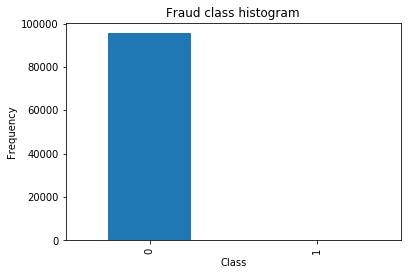

In [110]:
# Fraud status of transaction 1 -yes or 0-No
pd.value_counts(df_train['FraudResult']).plot.bar()
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
df_train['FraudResult'].value_counts()

In [4]:
df_train.tail()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13T09:54:25Z,2,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13T09:54:35Z,2,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13T10:01:10Z,2,0
95661,TransactionId_35670,BatchId_29317,AccountId_4841,SubscriptionId_3829,CustomerId_1709,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:01:28Z,2,0


In [5]:
# Print out what df_test looks like
df_test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


In [6]:
# Let's look at the size of both files
print(df_train.shape)
print(df_test.shape)

(95662, 16)
(45019, 15)


In [0]:
# Combining both dataframe to one dataframe
df = pd.concat([df_train, df_test], axis=0, sort=True)

In [8]:
# Check few entries of df
df.head()

,AccountId,Amount,BatchId,ChannelId,CountryCode,CurrencyCode,CustomerId,FraudResult,PricingStrategy,ProductCategory,ProductId,ProviderId,SubscriptionId,TransactionId,TransactionStartTime,Value
0,AccountId_3957,1000.0,BatchId_36123,ChannelId_3,256,UGX,CustomerId_4406,0.0,2,airtime,ProductId_10,ProviderId_6,SubscriptionId_887,TransactionId_76871,2018-11-15T02:18:49Z,1000
1,AccountId_4841,-20.0,BatchId_15642,ChannelId_2,256,UGX,CustomerId_4406,0.0,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_73770,2018-11-15T02:19:08Z,20
2,AccountId_4229,500.0,BatchId_53941,ChannelId_3,256,UGX,CustomerId_4683,0.0,2,airtime,ProductId_1,ProviderId_6,SubscriptionId_222,TransactionId_26203,2018-11-15T02:44:21Z,500
3,AccountId_648,20000.0,BatchId_102363,ChannelId_3,256,UGX,CustomerId_988,0.0,2,utility_bill,ProductId_21,ProviderId_1,SubscriptionId_2185,TransactionId_380,2018-11-15T03:32:55Z,21800
4,AccountId_4841,-644.0,BatchId_38780,ChannelId_2,256,UGX,CustomerId_988,0.0,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_28195,2018-11-15T03:34:21Z,644


In [9]:
# Let's look at the size of df
df.shape

(140681, 16)

In [10]:
# Check tail end of df
df.tail()

,AccountId,Amount,BatchId,ChannelId,CountryCode,CurrencyCode,CustomerId,FraudResult,PricingStrategy,ProductCategory,ProductId,ProviderId,SubscriptionId,TransactionId,TransactionStartTime,Value
45014,AccountId_4841,-5000.0,BatchId_117348,ChannelId_3,256,UGX,CustomerId_5225,NaN,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_116198,2019-03-14T23:56:28Z,5000
45015,AccountId_4803,10000.0,BatchId_53630,ChannelId_3,256,UGX,CustomerId_5272,NaN,1,airtime,ProductId_10,ProviderId_3,SubscriptionId_1738,TransactionId_24829,2019-03-14T23:57:38Z,10000
45016,AccountId_4817,10000.0,BatchId_112209,ChannelId_3,256,UGX,CustomerId_5286,NaN,1,airtime,ProductId_10,ProviderId_3,SubscriptionId_4613,TransactionId_102920,2019-03-14T23:59:17Z,10000
45017,AccountId_4841,-5000.0,BatchId_58734,ChannelId_3,256,UGX,CustomerId_5286,NaN,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_128439,2019-03-14T23:59:39Z,5000
45018,AccountId_4593,3500.0,BatchId_98308,ChannelId_3,256,UGX,CustomerId_5057,NaN,4,airtime,ProductId_3,ProviderId_5,SubscriptionId_3866,TransactionId_45927,2019-03-14T23:59:51Z,3500


In [0]:
# create a year column from TransactionStartTime column
df['Year'] = pd.DatetimeIndex(df['TransactionStartTime']).year

In [12]:
# check the newly created column Year
df.head()

,AccountId,Amount,BatchId,ChannelId,CountryCode,CurrencyCode,CustomerId,FraudResult,PricingStrategy,ProductCategory,ProductId,ProviderId,SubscriptionId,TransactionId,TransactionStartTime,Value,Year
0,AccountId_3957,1000.0,BatchId_36123,ChannelId_3,256,UGX,CustomerId_4406,0.0,2,airtime,ProductId_10,ProviderId_6,SubscriptionId_887,TransactionId_76871,2018-11-15T02:18:49Z,1000,2018
1,AccountId_4841,-20.0,BatchId_15642,ChannelId_2,256,UGX,CustomerId_4406,0.0,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_73770,2018-11-15T02:19:08Z,20,2018
2,AccountId_4229,500.0,BatchId_53941,ChannelId_3,256,UGX,CustomerId_4683,0.0,2,airtime,ProductId_1,ProviderId_6,SubscriptionId_222,TransactionId_26203,2018-11-15T02:44:21Z,500,2018
3,AccountId_648,20000.0,BatchId_102363,ChannelId_3,256,UGX,CustomerId_988,0.0,2,utility_bill,ProductId_21,ProviderId_1,SubscriptionId_2185,TransactionId_380,2018-11-15T03:32:55Z,21800,2018
4,AccountId_4841,-644.0,BatchId_38780,ChannelId_2,256,UGX,CustomerId_988,0.0,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_28195,2018-11-15T03:34:21Z,644,2018


In [0]:
# Drop the TransactionStartTime  column we will only use the year column
df.drop(['TransactionStartTime'], axis = 1, inplace = True)

In [14]:
df.head()

,AccountId,Amount,BatchId,ChannelId,CountryCode,CurrencyCode,CustomerId,FraudResult,PricingStrategy,ProductCategory,ProductId,ProviderId,SubscriptionId,TransactionId,Value,Year
0,AccountId_3957,1000.0,BatchId_36123,ChannelId_3,256,UGX,CustomerId_4406,0.0,2,airtime,ProductId_10,ProviderId_6,SubscriptionId_887,TransactionId_76871,1000,2018
1,AccountId_4841,-20.0,BatchId_15642,ChannelId_2,256,UGX,CustomerId_4406,0.0,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_73770,20,2018
2,AccountId_4229,500.0,BatchId_53941,ChannelId_3,256,UGX,CustomerId_4683,0.0,2,airtime,ProductId_1,ProviderId_6,SubscriptionId_222,TransactionId_26203,500,2018
3,AccountId_648,20000.0,BatchId_102363,ChannelId_3,256,UGX,CustomerId_988,0.0,2,utility_bill,ProductId_21,ProviderId_1,SubscriptionId_2185,TransactionId_380,21800,2018
4,AccountId_4841,-644.0,BatchId_38780,ChannelId_2,256,UGX,CustomerId_988,0.0,2,financial_services,ProductId_6,ProviderId_4,SubscriptionId_3829,TransactionId_28195,644,2018


In [15]:
# Check Currency Code
df['CurrencyCode'].describe()

count     140681
unique         1
top          UGX
freq      140681
Name: CurrencyCode, dtype: object

It looks like we are dealing with one currency

In [16]:
# Check Country Code
df['CountryCode'].describe

<bound method NDFrame.describe of 0        256
1        256
2        256
3        256
4        256
5        256
6        256
7        256
8        256
9        256
10       256
11       256
12       256
13       256
14       256
15       256
16       256
17       256
18       256
19       256
20       256
21       256
22       256
23       256
24       256
25       256
26       256
27       256
28       256
29       256
        ... 
44989    256
44990    256
44991    256
44992    256
44993    256
44994    256
44995    256
44996    256
44997    256
44998    256
44999    256
45000    256
45001    256
45002    256
45003    256
45004    256
45005    256
45006    256
45007    256
45008    256
45009    256
45010    256
45011    256
45012    256
45013    256
45014    256
45015    256
45016    256
45017    256
45018    256
Name: CountryCode, Length: 140681, dtype: int64>

It looks like we are dealing with with one country

In [0]:
# Drop Columns that won't be useful

df.drop(['SubscriptionId','ProductId','ChannelId','CustomerId', 'CurrencyCode', 'CountryCode'], axis = 1, inplace = True)

In [18]:
# check what we are left with now
df.head()

,AccountId,Amount,BatchId,FraudResult,PricingStrategy,ProductCategory,ProviderId,TransactionId,Value,Year
0,AccountId_3957,1000.0,BatchId_36123,0.0,2,airtime,ProviderId_6,TransactionId_76871,1000,2018
1,AccountId_4841,-20.0,BatchId_15642,0.0,2,financial_services,ProviderId_4,TransactionId_73770,20,2018
2,AccountId_4229,500.0,BatchId_53941,0.0,2,airtime,ProviderId_6,TransactionId_26203,500,2018
3,AccountId_648,20000.0,BatchId_102363,0.0,2,utility_bill,ProviderId_1,TransactionId_380,21800,2018
4,AccountId_4841,-644.0,BatchId_38780,0.0,2,financial_services,ProviderId_4,TransactionId_28195,644,2018


In [19]:
df.tail()

,AccountId,Amount,BatchId,FraudResult,PricingStrategy,ProductCategory,ProviderId,TransactionId,Value,Year
45014,AccountId_4841,-5000.0,BatchId_117348,NaN,2,financial_services,ProviderId_4,TransactionId_116198,5000,2019
45015,AccountId_4803,10000.0,BatchId_53630,NaN,1,airtime,ProviderId_3,TransactionId_24829,10000,2019
45016,AccountId_4817,10000.0,BatchId_112209,NaN,1,airtime,ProviderId_3,TransactionId_102920,10000,2019
45017,AccountId_4841,-5000.0,BatchId_58734,NaN,2,financial_services,ProviderId_4,TransactionId_128439,5000,2019
45018,AccountId_4593,3500.0,BatchId_98308,NaN,4,airtime,ProviderId_5,TransactionId_45927,3500,2019


In [20]:
df['ProductCategory'].describe()

count                 140681
unique                    10
top       financial_services
freq                   67105
Name: ProductCategory, dtype: object

In [21]:
df['ProviderId'].describe()

count           140681
unique               6
top       ProviderId_4
freq             56445
Name: ProviderId, dtype: object

In [22]:
df['PricingStrategy'].describe

<bound method NDFrame.describe of 0        2
1        2
2        2
3        2
4        2
5        2
6        4
7        2
8        2
9        2
10       2
11       2
12       2
13       2
14       2
15       2
16       2
17       2
18       2
19       4
20       2
21       4
22       2
23       2
24       2
25       2
26       2
27       2
28       2
29       2
        ..
44989    2
44990    1
44991    2
44992    4
44993    1
44994    2
44995    1
44996    2
44997    1
44998    1
44999    1
45000    2
45001    1
45002    2
45003    2
45004    2
45005    2
45006    1
45007    2
45008    2
45009    1
45010    2
45011    1
45012    2
45013    1
45014    2
45015    1
45016    1
45017    2
45018    4
Name: PricingStrategy, Length: 140681, dtype: int64>

In [23]:
df['BatchId'].describe()

count            140681
unique           139493
top       BatchId_67019
freq                 28
Name: BatchId, dtype: object

Need to deal with the ordinality in the PricingStrategy column by creating dummy variables

In [0]:
# Encode PricingStrategy column
categorical = ['PricingStrategy']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [25]:
df.head()

,AccountId,Amount,BatchId,FraudResult,ProductCategory,ProviderId,TransactionId,Value,Year,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4
0,AccountId_3957,1000.0,BatchId_36123,0.0,airtime,ProviderId_6,TransactionId_76871,1000,2018,0,0,1,0
1,AccountId_4841,-20.0,BatchId_15642,0.0,financial_services,ProviderId_4,TransactionId_73770,20,2018,0,0,1,0
2,AccountId_4229,500.0,BatchId_53941,0.0,airtime,ProviderId_6,TransactionId_26203,500,2018,0,0,1,0
3,AccountId_648,20000.0,BatchId_102363,0.0,utility_bill,ProviderId_1,TransactionId_380,21800,2018,0,0,1,0
4,AccountId_4841,-644.0,BatchId_38780,0.0,financial_services,ProviderId_4,TransactionId_28195,644,2018,0,0,1,0


In [0]:
# Encode Productcategory column and ProviderId column
category = ['ProductCategory', 'ProviderId']

for var in category:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [0]:
df.drop(['AccountId', 'TransactionId', 'BatchId'], axis = 1, inplace = True)

In [0]:
df.drop(['AccountId', 'BatchId'], axis = 1, inplace = True)

In [46]:
df.head()

,Amount,FraudResult,Value,Year,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_retail,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ProviderId_ProviderId_1,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6
0,1000.0,0.0,1000,2018,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-20.0,0.0,20,2018,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,500.0,0.0,500,2018,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,20000.0,0.0,21800,2018,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,-644.0,0.0,644,2018,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# Divide df dataset into train and test data
train = df[pd.notnull(df['FraudResult'])]
test = df[pd.isnull(df['FraudResult'])].drop(['FraudResult'], axis=1)

In [52]:
train.shape

(95662, 24)

In [53]:
test.shape

(45019, 23)

In [0]:
# Create X from features and y from output
X = train.drop(['FraudResult'], axis = 1)
y = train['FraudResult']

Notice that some of the variables have a wide range of values (like the Amount, Value variable). In order to get all variables in an equivalent range, we subtract the mean and divide by the standard deviation such that the distribution of the values is normalized:

In [120]:
X['normAmount'] = StandardScaler().fit_transform(X['Amount'].values.reshape(-1, 1))
X['normValue'] = StandardScaler().fit_transform(X['Value'].values.reshape(-1, 1))
X = X.drop(['Year', 'Amount', 'Value'], axis=1)
X.head()

,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_retail,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ProviderId_ProviderId_1,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6,normAmount,normValue
0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.046371,-0.072291
1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.054643,-0.080251
2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.050426,-0.076352
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0.107717,0.096648
4,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.059704,-0.075183


In [122]:
# View the features
X[0:10]

,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_retail,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ProviderId_ProviderId_1,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6,normAmount,normValue
0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.046371,-0.072291
1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.054643,-0.080251
2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.050426,-0.076352
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0.107717,0.096648
4,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.059704,-0.075183
5,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.038261,-0.064169
6,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.026618,0.000807
7,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.058536,-0.076352
8,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.050426,-0.076352
9,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.049615,-0.075540


In [123]:
# View the target data
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FraudResult, dtype: float64

# **Logistic Regression**

In [0]:


C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')

In [0]:
# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [125]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)
print("Number transactions test dataset: ", test.shape)

Number transactions X_train dataset:  (66963, 23)
Number transactions y_train dataset:  (66963,)
Number transactions X_test dataset:  (28699, 23)
Number transactions y_test dataset:  (28699,)
Number transactions test dataset:  (45019, 23)


In [128]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 137
Before OverSampling, counts of label '0': 66826 

After OverSampling, the shape of train_X: (133652, 23)
After OverSampling, the shape of train_y: (133652,) 

After OverSampling, counts of label '1': 66826
After OverSampling, counts of label '0': 66826


In [133]:
# Define the model - we are using Logistic Regression model
parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression(C=4,penalty='l1', verbose=5)
clf = GridSearchCV(lr, parameters, cv=5, verbose=3, n_jobs=3)
# Fit and predict!
lr = clf.fit(X_train_res, y_train_res.ravel())


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   11.7s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   22.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

In [159]:
y_pred = lr.predict(X_test)

# And finally: show the results
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     28643
         1.0       0.19      0.95      0.32        56

    accuracy                           0.99     28699
   macro avg       0.59      0.97      0.66     28699
weighted avg       1.00      0.99      0.99     28699



This is actually a great result! The 0 classes (transactions without fraud) are predicted with 100% precision and 99% recall. It has some issues with predicting the 1 classes (transactions which are fraudulent). It can predict fraud with 19% precision. This means that 81% of the transactions which are fraudulent remain undetected by the system. But, 19% is still quite not good!

Submission file for Logistic Regression Model

In [0]:
#submission
submission = df_test[['TransactionId']]

In [68]:
submission['FraudResult'] = y_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [70]:
submission.shape


(45019, 2)

In [71]:
submission.tail()

,TransactionId,FraudResult
45014,TransactionId_116198,0.0
45015,TransactionId_24829,0.0
45016,TransactionId_102920,0.0
45017,TransactionId_128439,0.0
45018,TransactionId_45927,0.0


In [0]:
submission.to_csv('submission.csv', index = False)

# **Random Forest**

In [0]:
# Train The Model using Random Forest
rf = RandomForestClassifier(random_state=42)

In [162]:
# Fiting the rf model
rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
# Predict the y values
y_pred = rf.predict(test)

In [178]:
# test our CV score
cross_val_score(rf, X_train, y_train, cv=5).mean()
# And finally: show the results
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28643
         1.0       0.90      0.84      0.87        56

    accuracy                           1.00     28699
   macro avg       0.95      0.92      0.94     28699
weighted avg       1.00      1.00      1.00     28699



**AUROC** represents the likelihood of our model distinguishing observations from two classes.

In [186]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf.predict(X_test))

0.9195555757826644

Our AUROC score is pretty decent

In [187]:
# test our cross_val_score
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.9992831898028129

Cross validation Score is a measure in sklearn to evaluate prediction model

Creating A Submission file for Random Forest Model


In [0]:
RandomForestSubmission = df_test[['TransactionId']]

In [192]:
RandomForestSubmission['FraudResult'] = y_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
RandomForestSubmission.to_csv('RandomForestSubmission.csv', index = False)

In [194]:
RandomForestSubmission.head()

,TransactionId,FraudResult
0,TransactionId_50600,0.0
1,TransactionId_95109,0.0
2,TransactionId_47357,0.0
3,TransactionId_28185,0.0
4,TransactionId_22140,0.0


Random Forest seems to work better than Logistic Regression

In [0]:
from google.colab import files
files.download("RandomForestSubmission.csv")